In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16,VGG19
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!unzip "/content/drive/MyDrive/Ballz.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/cricket_ball/cricket_ball_182.jpg  
  inflating: train/cricket_ball/cricket_ball_183.jpg  
  inflating: train/cricket_ball/cricket_ball_185.jpg  
  inflating: train/cricket_ball/cricket_ball_186.jpg  
  inflating: train/cricket_ball/cricket_ball_187.jpg  
  inflating: train/cricket_ball/cricket_ball_189.jpg  
  inflating: train/cricket_ball/cricket_ball_19.jpg  
  inflating: train/cricket_ball/cricket_ball_190.jpg  
  inflating: train/cricket_ball/cricket_ball_191.jpg  
  inflating: train/cricket_ball/cricket_ball_192.jpg  
  inflating: train/cricket_ball/cricket_ball_195.jpg  
  inflating: train/cricket_ball/cricket_ball_196.jpg  
  inflating: train/cricket_ball/cricket_ball_199.jpg  
  inflating: train/cricket_ball/cricket_ball_200.jpg  
  inflating: train/cricket_ball/cricket_ball_201.jpg  
  inflating: train/cricket_ball/cricket_ball_202.jpg  
  inflating: train/cricket_ball/cricket_ball_209.jpg  
  inflating: tr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batch_size = 16*4
file_names = []
labels = []
for class_name in os.listdir('/content/train'):
    class_dir = os.path.join('/content/train', class_name)
    for file_name in os.listdir(class_dir):
        file_names.append(os.path.join(class_dir, file_name))
        labels.append(class_name)


train_files, val_files, train_labels, val_labels = train_test_split(
    file_names, labels, test_size=0.2, random_state=42
)


train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": train_files, "label": train_labels}),
    directory=None,
    x_col="filename",
    y_col="label",
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
)
test_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": val_files, "label": val_labels}),
    directory=None,
    x_col="filename",
    y_col="label",
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size = (256,256),
    batch_size = batch_size,
    class_mode = 'categorical'
)


Found 5862 validated image filenames belonging to 15 classes.
Found 1466 validated image filenames belonging to 15 classes.
Found 1841 images belonging to 15 classes.


['american_football' 'baseball' 'basketball' 'billiard_ball'
 'bowling_ball' 'cricket_ball' 'football' 'golf_ball' 'hockey_ball'
 'hockey_puck' 'rugby_ball' 'shuttlecock' 'table_tennis_ball'
 'tennis_ball' 'volleyball']


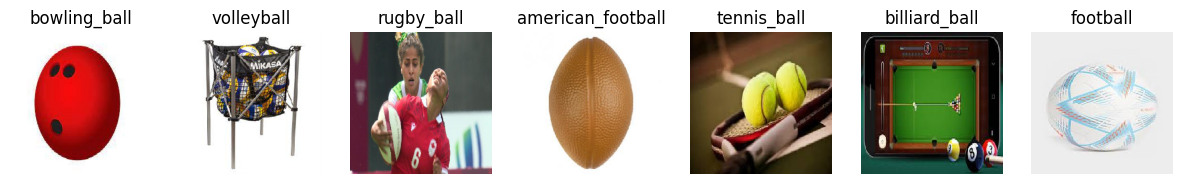

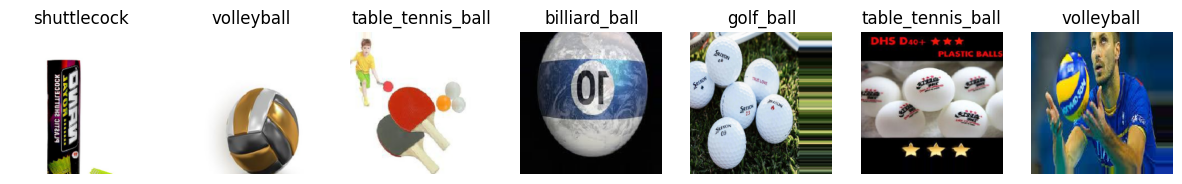

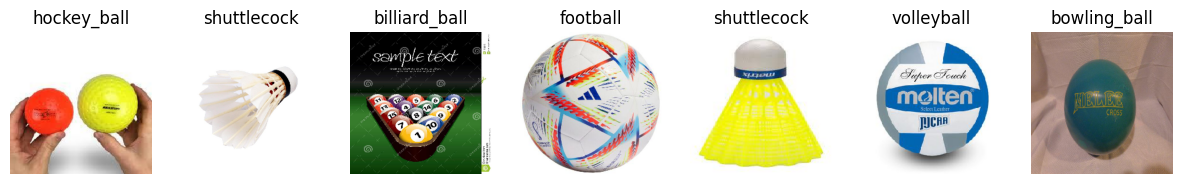

In [ ]:
print(np.unique(labels))

import matplotlib.pyplot as plt

def display_images_with_labels(generator, num_images=7):

    class_labels = list(generator.class_indices.keys())


    batch = generator.next()


    images = batch[0]
    labels = batch[1]


    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(class_labels[labels[i].argmax()])
        plt.axis('off')
    plt.show()

display_images_with_labels(val_generator)
display_images_with_labels(train_generator)
display_images_with_labels(test_generator)


In [ ]:
def define_model(num_classes):
    model = Sequential()
    conv_base = VGG19(
        weights=None,
        include_top=False,
        input_shape=(256, 256, 3)
    )
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256 * 4, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(120 * 2, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    return model

In [ ]:
def define_model(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    return model

In [ ]:
model = define_model(len(np.unique(labels)))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [ ]:
model = keras.saving.load_model("/content/drive/MyDrive/ComVis/SimpleCNN.keras")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)      

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', verbose = 1,
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

model_checkpoint_callback = ModelCheckpoint(
    filepath="/content/drive/MyDrive/Pickle/SimpleCNN_help.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history1 = model.fit(train_generator,epochs=200,validation_data = val_generator, callbacks=[early_stop,model_checkpoint_callback ], verbose = 1)


Epoch 1/200
92/92 [==============================] - 137s 1s/step - loss: 2.8373 - accuracy: 0.1431 - val_loss: 2.5105 - val_accuracy: 0.1726
Epoch 2/200
92/92 [==============================] - 127s 1s/step - loss: 2.4627 - accuracy: 0.2211 - val_loss: 2.3206 - val_accuracy: 0.2708
Epoch 3/200
92/92 [==============================] - 132s 1s/step - loss: 2.3191 - accuracy: 0.2728 - val_loss: 2.2095 - val_accuracy: 0.3247
Epoch 4/200
92/92 [==============================] - 131s 1s/step - loss: 2.2006 - accuracy: 0.3103 - val_loss: 2.0937 - val_accuracy: 0.3506
Epoch 5/200
92/92 [==============================] - 122s 1s/step - loss: 2.1140 - accuracy: 0.3439 - val_loss: 2.0271 - val_accuracy: 0.3568
Epoch 6/200
92/92 [==============================] - 127s 1s/step - loss: 2.0433 - accuracy: 0.3535 - val_loss: 1.9881 - val_accuracy: 0.3738
Epoch 7/200
92/92 [==============================] - 135s 1s/step - loss: 2.0348 - accuracy: 0.3613 - val_loss: 1.9176 - val_accuracy: 0.4141
Epoch 

In [ ]:
# Save the model
model.save("/content/drive/MyDrive/ComVis/SimpleCNN.keras")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'],color='red',label='train')
plt.plot(history1.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

NameError: name 'history1' is not defined

29/29 [==============================] - 11s 381ms/step


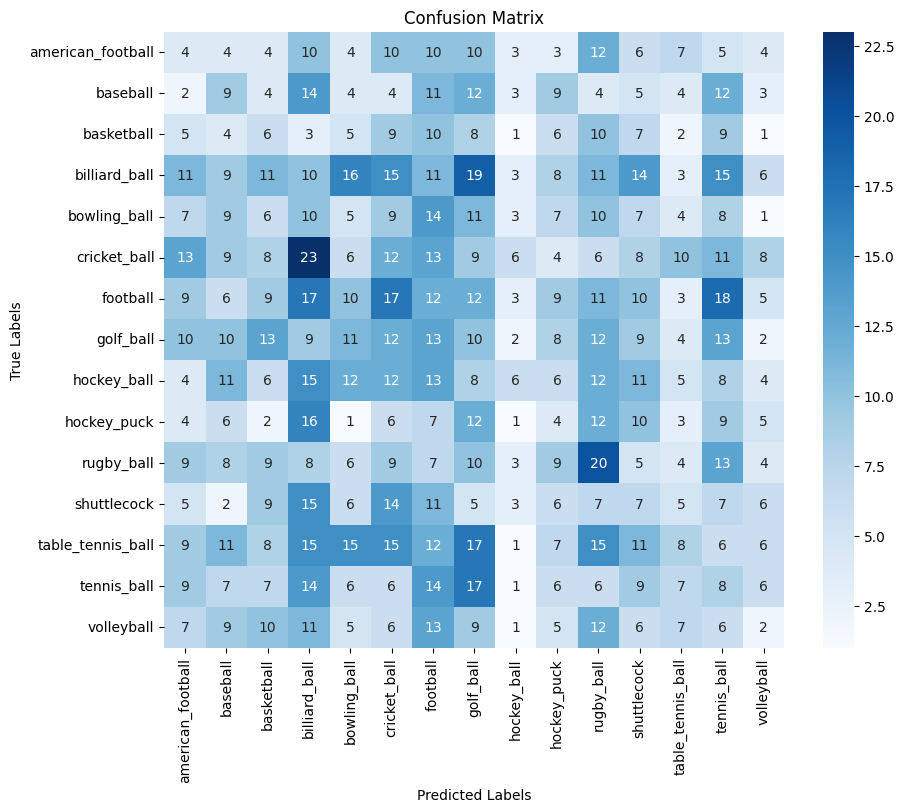

                   precision    recall  f1-score   support

american_football       0.04      0.04      0.04        96
         baseball       0.08      0.09      0.08       100
       basketball       0.05      0.07      0.06        86
    billiard_ball       0.05      0.06      0.06       162
     bowling_ball       0.04      0.05      0.04       111
     cricket_ball       0.08      0.08      0.08       146
         football       0.07      0.08      0.07       151
        golf_ball       0.06      0.07      0.07       138
      hockey_ball       0.15      0.05      0.07       133
      hockey_puck       0.04      0.04      0.04        98
       rugby_ball       0.12      0.16      0.14       124
      shuttlecock       0.06      0.06      0.06       108
table_tennis_ball       0.11      0.05      0.07       156
      tennis_ball       0.05      0.07      0.06       123
       volleyball       0.03      0.02      0.02       109

         accuracy                           0.07      

In [ ]:
def evaluate_model(model, val_generator):

    y_pred = model.predict(val_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)


    true_classes = val_generator.classes


    cm = confusion_matrix(true_classes, y_pred_classes)


    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


    target_names = list(val_generator.class_indices.keys())
    print(classification_report(true_classes, y_pred_classes, target_names=target_names))


evaluate_model(model, test_generator)